In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate
import time
%matplotlib inline  
import sys
sys.path.append('/gpfs2/projects/project-bus_capstone_2016/workspace/jz2308/bus-Capstone')

# these two modules are homemade
import gtfs
import arrivals
import ttools
os.chdir('/gpfs2/projects/project-bus_capstone_2016/workspace/share')

In [2]:
# get all the schedule data. (subset can be created later)
trips = gtfs.load_trips('2015-12-03','gtfs/')
stops = gtfs.load_stops('2015-12-03','gtfs/')
stop_times, tz_sched = gtfs.load_stop_times('2015-12-03','gtfs/')
tcal=gtfs.TransitCalendar('2015-12-03')
thurs_services = tcal.get_service_ids('2015-12-03')
thurs_trips = trips.service_id.isin(thurs_services)
thurs_stops = stop_times.reset_index().set_index('trip_id').loc[thurs_trips]
print 'Finished loading GTFS data.'

Finished loading GTFS data.


In [3]:
interpolated = pd.read_csv('2015-12-03_interpolated.csv')

In [4]:
interpolated.head()

,route,trip_id,trip_date,vehicle_id,stop_id,interpolated_arrival_time
0,MTA NYCT_M101,OH_D5-Weekday-SDon-036500_M101_38,2015-12-03,MTA NYCT_5879,402805,0 days 06:10:56.778916
1,MTA NYCT_M101,OH_D5-Weekday-SDon-036500_M101_38,2015-12-03,MTA NYCT_5879,405057,0 days 06:14:24.977703
2,MTA NYCT_M101,OH_D5-Weekday-SDon-036500_M101_38,2015-12-03,MTA NYCT_5879,403416,0 days 06:16:58.526210
3,MTA NYCT_M101,OH_D5-Weekday-SDon-036500_M101_38,2015-12-03,MTA NYCT_5879,402809,0 days 06:17:25.226045
4,MTA NYCT_M101,OH_D5-Weekday-SDon-036500_M101_38,2015-12-03,MTA NYCT_5879,402811,0 days 06:18:36.819142


In [5]:
interpolated = interpolated.merge(stop_times[['arrival_time','stop_sequence']],how='left',left_on=['trip_id','stop_id'],right_index=True)

In [6]:
interpolated['interpolated_arrival_time'] = pd.to_timedelta(interpolated['interpolated_arrival_time'])
interpolated['arrival_time'] = pd.to_timedelta(interpolated['arrival_time'])

In [7]:
# bools = interpolated.duplicated(subset=['route','trip_id','trip_date','vehicle_id','stop_id'],take_last=False) + interpolated.duplicated(subset=['route','trip_id','trip_date','vehicle_id','stop_id'],take_last=True)
# interpolated[bools].sort(['route','trip_id','trip_date','vehicle_id']).shape

In [8]:
interpolated.set_index(['route','trip_id','trip_date','vehicle_id','stop_sequence','stop_id'],inplace=True)

In [10]:
grouped = interpolated.groupby(level=(0,1,2,3))
begins = grouped.min()
ends = grouped.max()
travel_times = begins.join(ends,lsuffix='_begin',rsuffix='_end')

In [18]:
def earliest_stop(g):
    return g.idxmin()[-1][-1]
def latest_stop(g):
    return g.idxmax()[-1][-1]
travel_times['earliest_stop'] = grouped.apply(earliest_stop)
travel_times['latest_stop'] = grouped.apply(latest_stop)

In [28]:
travel_times['ttime_schedule'] = (travel_times['arrival_time_end'] - travel_times['arrival_time_begin'])/ttools.datetime.timedelta(seconds=1)
travel_times['ttime_actual'] = (travel_times['interpolated_arrival_time_end'] - travel_times['interpolated_arrival_time_begin'])/ttools.datetime.timedelta(seconds=1)

In [52]:
# travel_times.reset_index().groupby(['route','earliest_stop','latest_stop'])['ttime_schedule'].median() - travel_times.reset_index().groupby(['route','earliest_stop','latest_stop'])['ttime_actual'].median()

In [37]:
sample_sizes = travel_times.reset_index().groupby(['route','earliest_stop','latest_stop']).size()
sample_sizes.groupby(level=0).idxmax()

route
MTA NYCT_B1        (MTA NYCT_B1, 300002, 305460)
MTA NYCT_B11      (MTA NYCT_B11, 307485, 306468)
MTA NYCT_B12      (MTA NYCT_B12, 301310, 301343)
MTA NYCT_B13      (MTA NYCT_B13, 301880, 801167)
MTA NYCT_B14      (MTA NYCT_B14, 301516, 307896)
MTA NYCT_B15      (MTA NYCT_B15, 503996, 301092)
MTA NYCT_B16      (MTA NYCT_B16, 301603, 307646)
MTA NYCT_B17      (MTA NYCT_B17, 307027, 301804)
MTA NYCT_B2        (MTA NYCT_B2, 300138, 307636)
MTA NYCT_B20      (MTA NYCT_B20, 503454, 307896)
MTA NYCT_B24      (MTA NYCT_B24, 302255, 302310)
MTA NYCT_B25      (MTA NYCT_B25, 307238, 302440)
MTA NYCT_B26      (MTA NYCT_B26, 307699, 801052)
MTA NYCT_B3        (MTA NYCT_B3, 300185, 300228)
MTA NYCT_B31      (MTA NYCT_B31, 302599, 300182)
MTA NYCT_B32      (MTA NYCT_B32, 551925, 306461)
MTA NYCT_B35      (MTA NYCT_B35, 302678, 307993)
MTA NYCT_B36      (MTA NYCT_B36, 308361, 302868)
MTA NYCT_B37      (MTA NYCT_B37, 301722, 901484)
MTA NYCT_B38      (MTA NYCT_B38, 307460, 503884)
MTA NYCT_B39  

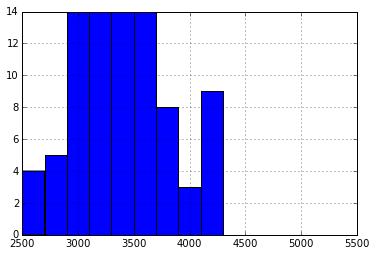

In [50]:
travel_times.loc['MTA NYCT_B41'].query('earliest_stop == 307460 & latest_stop == 307636')['ttime_schedule'].hist(range=(2500,5500),bins=15)

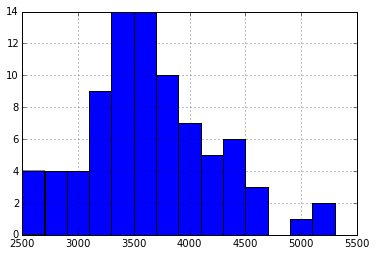

In [51]:
travel_times.loc['MTA NYCT_B41'].query('earliest_stop == 307460 & latest_stop == 307636')['ttime_actual'].hist(range=(2500,5500),bins=15)